In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
new_data = pd.read_csv("C://Users/dadel/Downloads/BACI_HS22_V202401b/BACI_HS22_Y2022_V202401b.csv")
new_cc = pd.read_csv("C://Users/dadel/Downloads/BACI_HS22_V202401b/country_codes_V202401b.csv")
new_pc = pd.read_csv("C://Users/dadel/Downloads/BACI_HS22_V202401b/product_codes_HS22_V202401b.csv")

            t  exporter  importer  product       value       quantity  \
3142432  2022       268        31   270300     589.754       6828.710   
3142433  2022       268        31   271000     433.437        285.548   
3142434  2022       268        31   271600     569.760             NA   
3142755  2022       268        36   271000       2.053          0.040   
3143279  2022       268        51   271000     418.545        402.011   
3143280  2022       268        51   271600    5971.342             NA   
3143670  2022       268        56   270750    1454.644       2547.170   
3143671  2022       268        56   271000   13943.040      20031.253   
3143922  2022       268       100   271112    1596.523       2379.550   
3145064  2022       268       196   270799   13082.924      31613.000   
3145203  2022       268       203   271000       3.292          0.680   
3145778  2022       268       233   271000       0.035          0.042   
3145955  2022       268       246   271000      27.

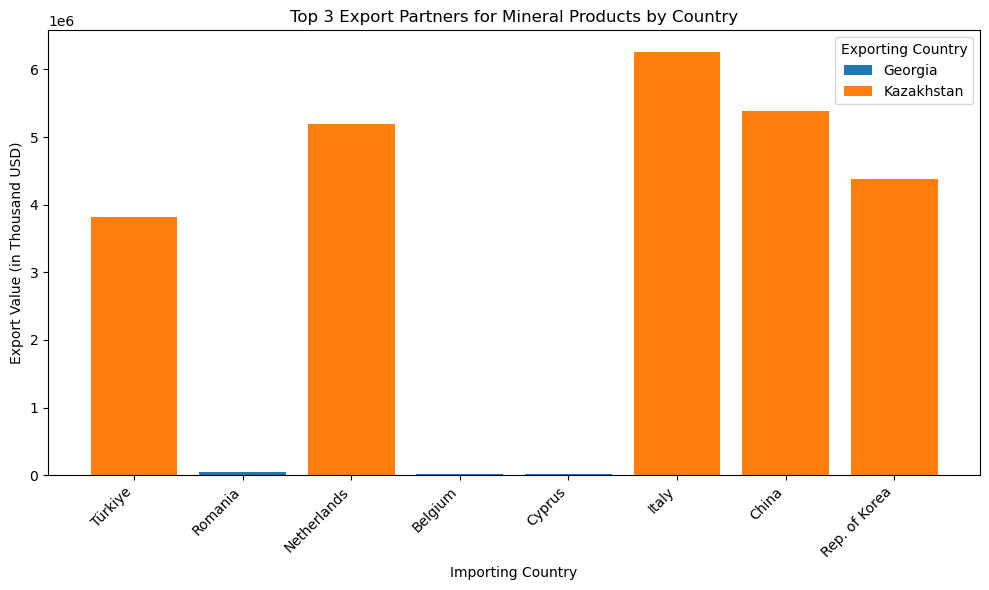

In [22]:
baci_data = new_data
country_codes = new_cc  
product_codes = new_pc
# Rename columns for clarit
baci_data = baci_data.rename(columns={'i': 'exporter', 'j': 'importer', 'k': 'product', 'v': 'value', 'q': 'quantity'})
country_codes.columns = ["country_code", "country_name", "country_iso2", "country_iso3"]
product_codes.columns = ["product", "description"]

# Merge exporter and importer country names
baci_data = (
    baci_data
    .merge(country_codes[['country_code', 'country_name']], left_on='exporter', right_on='country_code', how='left')
    .rename(columns={'country_name': 'exporter_name'})
    .drop(columns=['country_code'])
)

baci_data = (
    baci_data
    .merge(country_codes[['country_code', 'country_name']], left_on='importer', right_on='country_code', how='left', suffixes=('', '_importer'))
    .rename(columns={'country_name': 'importer_name'})
    .drop(columns=['country_code'])
)

# Drop any duplicate rows if they exist
baci_data = baci_data.drop_duplicates()

# Verify 'importer_name' column exists and check for missing values
if 'importer_name' in baci_data.columns and baci_data['importer_name'].isnull().any():
    print("Warning: Some 'importer_name' values are missing. Dropping these rows.")
    baci_data = baci_data.dropna(subset=['importer_name'])

# Merge product descriptions
baci_data = baci_data.merge(product_codes, on='product', how='left')

# Filter for Mineral Products (HS codes 25-27) and top 3 export partners
def get_top_export_partners_for_minerals(country_name):
    # Get country code
    country_code = country_codes[country_codes['country_name'] == country_name]['country_code'].values[0]
    
    # Filter for exports from the specified country
    country_exports = baci_data[baci_data['exporter'] == country_code]
    
    # Filter for Mineral Products (HS codes 25-27)
    mineral_exports = country_exports[country_exports['product'].astype(str).str[:2].isin(['27'])]
    print(mineral_exports)
    # Drop any remaining rows with missing importer names
    mineral_exports = mineral_exports.dropna(subset=['importer_name'])

    # Get the top 3 partners by export value
    top_export_partners = (
        mineral_exports
        .groupby('importer_name')['value']
        .sum()
        .sort_values(ascending=False)
        .head(5)
    )
    return top_export_partners

# Define countries of interest
countries_of_interest = ["Georgia", "Kazakhstan", "Russia"]  # Replace with actual country names as desired

# Collect data for plotting
top_partners_data = {}

for country in countries_of_interest:
    try:
        top_partners = get_top_export_partners_for_minerals(country)
        top_partners_data[country] = top_partners
    except IndexError:
        print(f"Country '{country}' not found in country codes.")

# Plotting results
fig, ax = plt.subplots(figsize=(10, 6))

for country, partners in top_partners_data.items():
    ax.bar(partners.index, partners.values, label=country)

# Customizing the plot
ax.set_title("Top 3 Export Partners for Mineral Products by Country")
ax.set_xlabel("Importing Country")
ax.set_ylabel("Export Value (in Thousand USD)")
ax.legend(title="Exporting Country")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()